In [1]:
from google.colab import drive
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from sklearn.preprocessing import normalize
import gc
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D 
from keras.models import Model
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras.layers import Dropout
from keras import backend as K
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
drive.mount('/content/drive')
root_path = 'drive/My Drive/Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [0]:
#load the training data of one single angle of the exams (axial | coronal | sagittal) by giving the angle name
def trainingSet(file_name):
    training_set = []
    for np_name in sorted(glob.glob('MRNet-v1.0/train/'+file_name+'/*.npy')):
        training_set.append(np.load(np_name))
    return training_set  

In [0]:
#load the labels of one knee tear(abnormal | acl | meniscus) by the giving the file name that contains the labels
def load_labels(train_file_name):
    training_labels = np.loadtxt(train_file_name, delimiter=',')[:,1]
    return training_labels

In [0]:
#as each exam (stack) contains S slices and most of the pretrained CNN models accept the image with channel = 3
#extract the middle 3 slices as most of the time they deside if the patiant has a certain tear or not
def extract_3(dataset, data_size):
    for i in range(len(dataset)):
        dataset[i] = list(dataset[i])
        middel_idx = int(len(dataset[i]) / 2)
        dataset[i] = dataset[i][middel_idx - 1 : middel_idx + 2]
        dataset[i] = np.array(dataset[i])
    dataset = np.array(dataset)
    dataset = dataset.reshape(data_size, 256, 256 ,3)
    return dataset

In [0]:
#load the training data for each angle of the knee
training_set_axial= trainingSet('axial')
training_set_coronal=trainingSet('coronal')
training_set_sagittal=trainingSet('sagittal')

In [0]:
#extract the middel 3 slices from each stack
training_set_axial = extract_3(training_set_axial, 1130)
training_set_coronal =extract_3(training_set_coronal, 1130)
training_set_sagittal =extract_3(training_set_sagittal, 1130)

In [9]:
training_set_axial.shape

(1130, 256, 256, 3)

In [0]:
#load the labels of the trainig data for each knee tear 
training_label_abnormal = load_labels('MRNet-v1.0/train-abnormal.csv')
training_label_acl = load_labels('MRNet-v1.0/train-acl.csv')
training_label_meniscus = load_labels('MRNet-v1.0/train-meniscus.csv')

In [11]:
training_label_abnormal.shape

(1130,)

In [0]:
datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.01,
        fill_mode='nearest')

In [0]:
def data_augmentation(dataset, labels):
  augmented_data = []
  augmented_labels = []
  num_augmented = 0
  for X_batch, y_batch in datagen.flow(dataset, labels, batch_size= dataset.shape[0], shuffle=False):
      augmented_data.append(X_batch)
      augmented_labels.append(y_batch)
      num_augmented += dataset.shape[0]
      if num_augmented == dataset.shape[0] * 2:
          break
          
  dataset = np.array(augmented_data).reshape(num_augmented, 256, 256, 3)
  labels = np.array(augmented_labels).reshape(num_augmented, 1)
  return dataset, labels

In [0]:
training_set_axial, training_label_abnormal = data_augmentation(training_set_axial, training_label_abnormal)

In [0]:
training_set_coronal, training_label_acl = data_augmentation(training_set_coronal, training_label_acl)

In [0]:
training_set_sagittal, training_label_meniscus = data_augmentation(training_set_sagittal, training_label_meniscus)

In [17]:
training_set_axial.shape

(2260, 256, 256, 3)

In [18]:
#load INCEPTIONV3 pretrainned model from keras without the top layer &
#specify the shape of the input image as (256x256x3) 
mri_InceptionV3 = InceptionV3(include_top = False, input_shape = (256, 256, 3))

#remove the last one
mri_InceptionV3.layers.pop()

#get the output of the INCEPTIONV# model "feature extraction" and add Dense layers so that the model is designed
#to classify our data
mri_InceptionV3_output = mri_InceptionV3.output

mri_InceptionV3_last_layer = GlobalMaxPooling2D()(mri_InceptionV3_output)

mri_InceptionV3_last_layer = Dense(1024, activation = 'relu')(mri_InceptionV3_last_layer)

mri_InceptionV3_last_layer = Dense(128, activation = 'relu')(mri_InceptionV3_last_layer)

mri_InceptionV3_last_layer = Dense(32, activation = 'relu')(mri_InceptionV3_last_layer)

predictor = Dense(1, activation='sigmoid')(mri_InceptionV3_last_layer)

modified_mri_InceptionV3 = Model(inputs = mri_InceptionV3.input, output = predictor)

modified_mri_InceptionV3.summary()

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [0]:
#freeze the added dense layers and unfreeze the rest:
for layer in modified_mri_InceptionV3.layers[15:]:
    layer.trainable = True 
    
for layer in mri_InceptionV3.layers:
    layer.trainable = False
    
modified_mri_InceptionV3.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [0]:
class Metrics(Callback):
  def on_train_begin(self, logs={}):
    self.val_f1s = []
  def on_epoch_end(self, epoch, logs={}):
    val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
    val_targ = self.validation_data[1]
    _val_f1 = f1_score(val_targ, val_predict)
    self.val_f1s.append(_val_f1)
    print ('-val_f1 : %f '%(_val_f1))
    return
metrics = Metrics()

In [0]:
def plot_history(history):
  plt.figure(figsize=(8, 6))
  ax = plt.gca()
  plt.title('Training performance')
  plt.plot(history.epoch, history.history['loss'], label='Loss')
  plt.plot(history.epoch, history.history['val_loss'], label='validation error')
  plt.plot(history.epoch, history.history['acc'], label='accuracy')
  plt.plot(history.epoch, history.history['val_acc'], label='validation accuracy')
  plt.plot(metrics.val_f1s, label='f_score')
  plt.grid(True,color='white')
  mpl.style.use('seaborn')
  plt.legend() 
  

In [0]:
#train the model with 1073 trainning data & 57 validation data
#save the model that has the max validation accuracy
#at the end plot the trainng loss & accuracy, validation loss & accuracy & F-score 
def fit_model(training_set, training_labels, model_file_name):
  
    history = modified_mri_InceptionV3.fit(x = training_set, y = training_labels, batch_size=32,
                       epochs=30, validation_split = 0.05,
                       callbacks =[
                          EarlyStopping(patience=3, monitor = 'val_loss', mode = 'min'),
                          ModelCheckpoint(model_file_name, monitor='val_acc', save_best_only=True, mode='max', period=1), metrics])
    plot_history(history)
    best_model = load_model(model_file_name)
    return best_model

Train on 2147 samples, validate on 113 samples
Epoch 1/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4070 - acc: 0.8295 - val_loss: 5.0151 - val_acc: 0.2035
-val_f1 : 0.021739 
Epoch 2/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.3952 - acc: 0.8337 - val_loss: 5.2926 - val_acc: 0.2212
-val_f1 : 0.063830 
Epoch 3/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.3878 - acc: 0.8267 - val_loss: 6.6724 - val_acc: 0.2035
-val_f1 : 0.021739 
Epoch 4/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.3649 - acc: 0.8449 - val_loss: 4.2279 - val_acc: 0.2212
-val_f1 : 0.063830 
Epoch 5/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.3829 - acc: 0.8314 - val_loss: 3.2198 - val_acc: 0.2566
-val_f1 : 0.160000 
Epoch 6/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.3702 - acc: 0.8365 - val_loss: 6.3825 - val_acc: 0.2035
-val_f1 : 0.021739 
Epoch 7/30
2147/2147 [=======

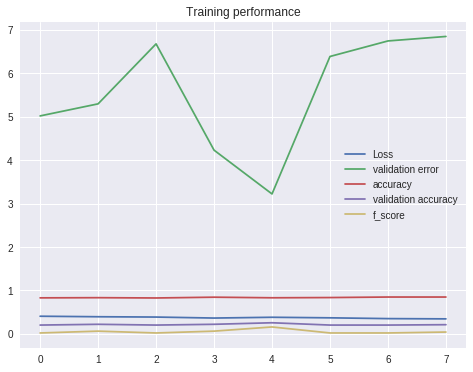

In [52]:
#train the modified INCEPTIONV3 model that will accept the axial data and classify the knee is it has an abnormal tear or not 
axial_abnormal_model = fit_model(training_set_axial, training_label_abnormal, "axial_abnormal_model")

Train on 2147 samples, validate on 113 samples
Epoch 1/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.5568 - acc: 0.7927 - val_loss: 0.4800 - val_acc: 0.8142
-val_f1 : 0.000000 
Epoch 2/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.5074 - acc: 0.7988 - val_loss: 2.4248 - val_acc: 0.8496
-val_f1 : 0.000000 
Epoch 3/30
  32/2147 [..............................] - ETA: 6s - loss: 0.5404 - acc: 0.7812

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2147/2147 [==============================] - 8s 4ms/step - loss: 0.4378 - acc: 0.8156 - val_loss: 2.4248 - val_acc: 0.8496
-val_f1 : 0.000000 
Epoch 4/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4364 - acc: 0.8165 - val_loss: 2.1940 - val_acc: 0.8496
-val_f1 : 0.000000 


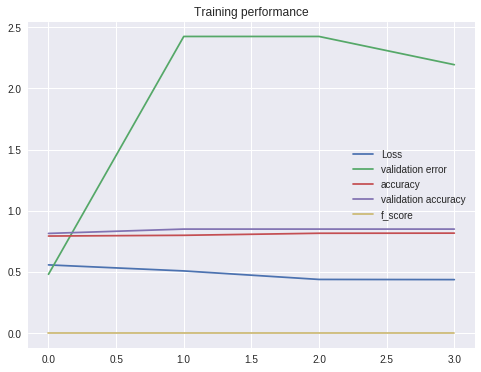

In [24]:
#train the modified INCEPTIONV3 model that will accept the axial data and classify the knee is it has an acl tear or not 
axial_acl_model = fit_model(training_set_axial, training_label_acl, "axial_acl_model")

Train on 2147 samples, validate on 113 samples
Epoch 1/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.6204 - acc: 0.6530 - val_loss: 2.8215 - val_acc: 0.6637
-val_f1 : 0.000000 
Epoch 2/30
  32/2147 [..............................] - ETA: 6s - loss: 0.5671 - acc: 0.7500

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2147/2147 [==============================] - 8s 4ms/step - loss: 0.5745 - acc: 0.6875 - val_loss: 5.4151 - val_acc: 0.6637
-val_f1 : 0.000000 
Epoch 3/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.5990 - acc: 0.6777 - val_loss: 0.9020 - val_acc: 0.6637
-val_f1 : 0.136364 
Epoch 4/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.5747 - acc: 0.6833 - val_loss: 5.2512 - val_acc: 0.6637
-val_f1 : 0.000000 
Epoch 5/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.5842 - acc: 0.6907 - val_loss: 2.5717 - val_acc: 0.6637
-val_f1 : 0.050000 
Epoch 6/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.5392 - acc: 0.7140 - val_loss: 4.5500 - val_acc: 0.6726
-val_f1 : 0.051282 


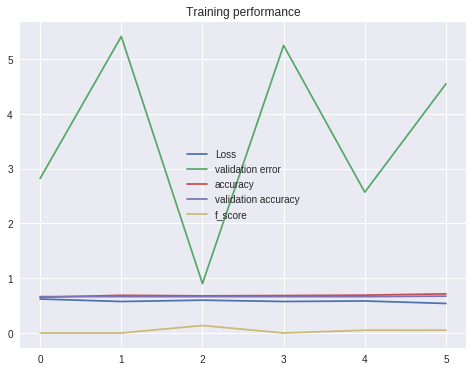

In [25]:
#train the modified INCEPTIONV3 model that will accept the axial data and classify the knee is it has a meniscus tear or not 
axial_meniscus_model = fit_model(training_set_axial, training_label_meniscus, "axial_meniscus_model")

Train on 2147 samples, validate on 113 samples
Epoch 1/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.5147 - acc: 0.7993 - val_loss: 2.2675 - val_acc: 0.8053
-val_f1 : 0.892157 
Epoch 2/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4747 - acc: 0.8081 - val_loss: 2.5541 - val_acc: 0.8053
-val_f1 : 0.892157 
Epoch 3/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4685 - acc: 0.8086 - val_loss: 1.6575 - val_acc: 0.8053
-val_f1 : 0.892157 
Epoch 4/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4377 - acc: 0.8100 - val_loss: 1.7343 - val_acc: 0.6726
-val_f1 : 0.800000 
Epoch 5/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4320 - acc: 0.8142 - val_loss: 1.6804 - val_acc: 0.7965
-val_f1 : 0.886700 
Epoch 6/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4166 - acc: 0.8081 - val_loss: 1.0946 - val_acc: 0.6637
-val_f1 : 0.788889 
Epoch 7/30
2147/2147 [=======

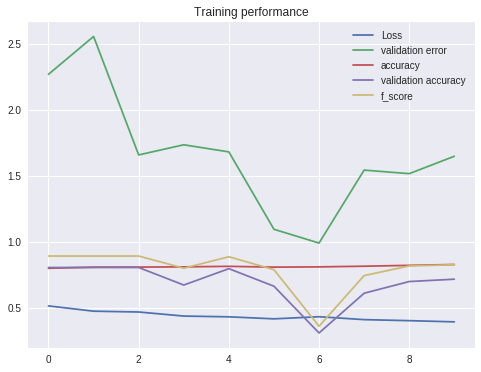

In [26]:
#train the modified INCEPTIONV3 model that will accept the coronal data and classify the knee is it has an abnormal tear or not 
coronal_abnormal_model = fit_model(training_set_coronal, training_label_abnormal, "coronal_abnormal_model")

Train on 2147 samples, validate on 113 samples
Epoch 1/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.5582 - acc: 0.7899 - val_loss: 1.5039 - val_acc: 0.8496
-val_f1 : 0.000000 
Epoch 2/30
  32/2147 [..............................] - ETA: 6s - loss: 0.2758 - acc: 0.9375

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2147/2147 [==============================] - 8s 4ms/step - loss: 0.4802 - acc: 0.8142 - val_loss: 1.9839 - val_acc: 0.8496
-val_f1 : 0.000000 
Epoch 3/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4736 - acc: 0.8142 - val_loss: 1.5012 - val_acc: 0.8496
-val_f1 : 0.000000 
Epoch 4/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4528 - acc: 0.8142 - val_loss: 1.6846 - val_acc: 0.8496
-val_f1 : 0.000000 
Epoch 5/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4625 - acc: 0.8142 - val_loss: 2.1236 - val_acc: 0.8496
-val_f1 : 0.000000 
Epoch 6/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4407 - acc: 0.8142 - val_loss: 1.9625 - val_acc: 0.8496
-val_f1 : 0.000000 


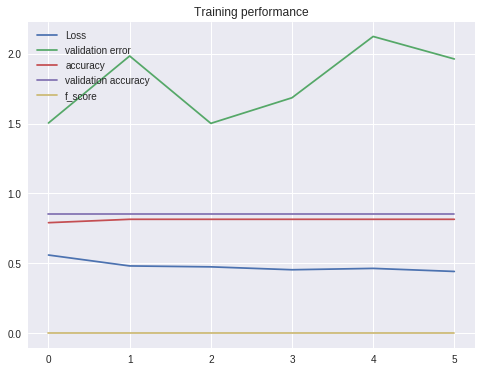

In [27]:
#train the modified INCEPTIONV3 model that will accept the coronal data and classify the knee is it has an acl tear or not 
coronal_acl_model = fit_model(training_set_coronal, training_label_acl, "coronal_acl_model")

Train on 2147 samples, validate on 113 samples
Epoch 1/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.6549 - acc: 0.6479 - val_loss: 0.7278 - val_acc: 0.5310
-val_f1 : 0.273973 
Epoch 2/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.6491 - acc: 0.6479 - val_loss: 0.7261 - val_acc: 0.5133
-val_f1 : 0.225352 
Epoch 3/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.6492 - acc: 0.6479 - val_loss: 0.6780 - val_acc: 0.5664
-val_f1 : 0.196721 
Epoch 4/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.6496 - acc: 0.6456 - val_loss: 0.6537 - val_acc: 0.6814
-val_f1 : 0.142857 
Epoch 5/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.6492 - acc: 0.6479 - val_loss: 0.6526 - val_acc: 0.6814
-val_f1 : 0.142857 
Epoch 6/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.6497 - acc: 0.6479 - val_loss: 0.6644 - val_acc: 0.6372
-val_f1 : 0.163265 
Epoch 7/30
2147/2147 [=======

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2147/2147 [==============================] - 8s 4ms/step - loss: 0.6405 - acc: 0.6479 - val_loss: 4.5026 - val_acc: 0.6637
-val_f1 : 0.000000 
Epoch 14/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.6504 - acc: 0.6479 - val_loss: 0.6381 - val_acc: 0.6549
-val_f1 : 0.000000 


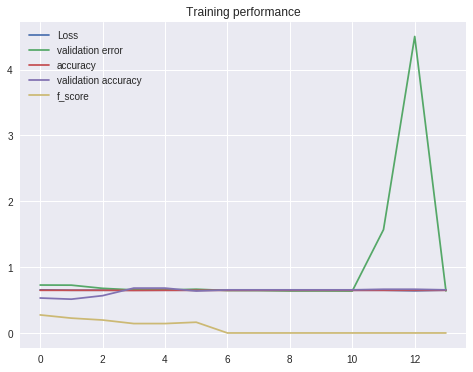

In [28]:
#train the modified INCEPTIONV3 model that will accept the coronal data and classify the knee is it has a meniscus tear or not 
coronal_meniscus_model = fit_model(training_set_coronal, training_label_meniscus, "coronal_meniscus_model")

Train on 2147 samples, validate on 113 samples
Epoch 1/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.7336 - acc: 0.4541 - val_loss: 0.6154 - val_acc: 0.8053
-val_f1 : 0.892157 
Epoch 2/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.5328 - acc: 0.8081 - val_loss: 0.5155 - val_acc: 0.8053
-val_f1 : 0.892157 
Epoch 3/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4921 - acc: 0.8081 - val_loss: 1.1393 - val_acc: 0.8053
-val_f1 : 0.892157 
Epoch 4/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4906 - acc: 0.8081 - val_loss: 0.5059 - val_acc: 0.8053
-val_f1 : 0.892157 
Epoch 5/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4893 - acc: 0.8081 - val_loss: 0.5058 - val_acc: 0.8053
-val_f1 : 0.892157 
Epoch 6/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4892 - acc: 0.8081 - val_loss: 0.5055 - val_acc: 0.8053
-val_f1 : 0.892157 
Epoch 7/30
2147/2147 [=======

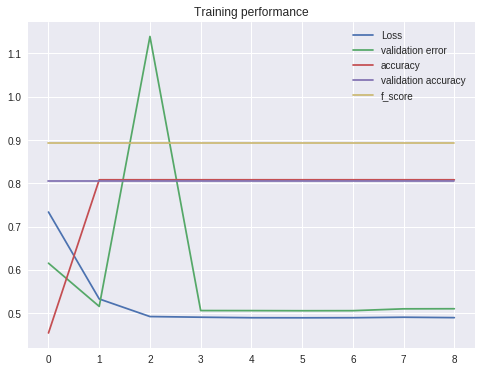

In [29]:
#train the modified INCEPTIONV3 model that will accept the sagittal data and classify the knee is it has an abnormal tear or not 
sagittal_abnormal_model = fit_model(training_set_sagittal, training_label_abnormal, "sagittal_abormal_model")

Train on 2147 samples, validate on 113 samples
Epoch 1/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.9034 - acc: 0.2627 - val_loss: 0.8302 - val_acc: 0.8496
-val_f1 : 0.000000 
Epoch 2/30
  32/2147 [..............................] - ETA: 7s - loss: 0.5264 - acc: 0.8125

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2147/2147 [==============================] - 8s 4ms/step - loss: 0.4849 - acc: 0.8142 - val_loss: 1.7688 - val_acc: 0.8496
-val_f1 : 0.000000 
Epoch 3/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4668 - acc: 0.8142 - val_loss: 1.4748 - val_acc: 0.8496
-val_f1 : 0.000000 
Epoch 4/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.4651 - acc: 0.8142 - val_loss: 1.9984 - val_acc: 0.8496
-val_f1 : 0.000000 


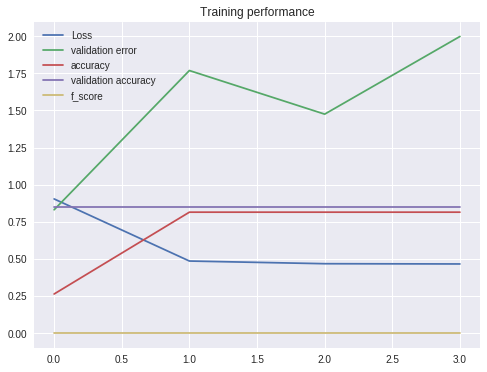

In [30]:
#train the modified INCEPTIONV3 model that will accept the sagittal data and classify the knee is it has an acl tear or not 
sagittal_acl_model = fit_model(training_set_sagittal, training_label_acl, "sagittal_acl_model")

Train on 2147 samples, validate on 113 samples
Epoch 1/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.6496 - acc: 0.6469 - val_loss: 2.6880 - val_acc: 0.6637
-val_f1 : 0.000000 
Epoch 2/30
  32/2147 [..............................] - ETA: 7s - loss: 0.5068 - acc: 0.8438

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2147/2147 [==============================] - 8s 4ms/step - loss: 0.6323 - acc: 0.6479 - val_loss: 3.1717 - val_acc: 0.6637
-val_f1 : 0.000000 
Epoch 3/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.6248 - acc: 0.6521 - val_loss: 3.7506 - val_acc: 0.6637
-val_f1 : 0.000000 
Epoch 4/30
2147/2147 [==============================] - 8s 4ms/step - loss: 0.6118 - acc: 0.6633 - val_loss: 4.2659 - val_acc: 0.6637
-val_f1 : 0.000000 


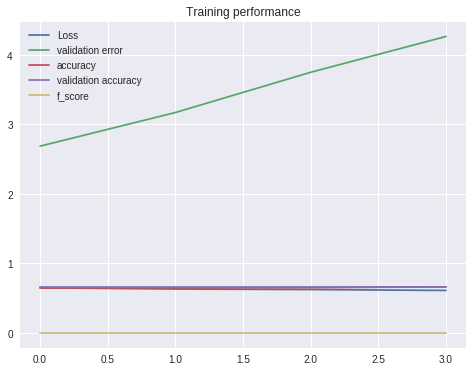

In [31]:
#train the modified INCEPTIONV3 model that will accept the sagittal data and classify the knee is it has a meniscus tear or not 
sagittal_meniscus_model = fit_model(training_set_sagittal, training_label_meniscus, "sagittal_meniscus_model")

## Evaluate the 9 models

In [0]:
#load the test data of one single angle of the exams (axial | coronal | sagittal) by giving the angle name
def testSet(file_name):
    test_set = []
    for np_name in sorted(glob.glob('MRNet-v1.0/valid/'+file_name+'/*.npy')):
        test_set.append(np.load(np_name))
    return test_set   

In [0]:
#load the test data for each angle of the knee
test_set_axial= testSet('axial')
test_set_coronal=testSet('coronal')
test_set_sagittal=testSet('sagittal')

In [0]:
#extract the middel 3 slices from each stack
test_set_axial = extract_3(test_set_axial, 120)
test_set_coronal =extract_3(test_set_coronal, 120)
test_set_sagittal =extract_3(test_set_sagittal, 120)

In [0]:
#load the labels of the test data for each knee tear 
test_label_abnormal = load_labels('MRNet-v1.0/valid-abnormal.csv')
test_label_acl = load_labels('MRNet-v1.0/valid-acl.csv')
test_label_meniscus = load_labels('MRNet-v1.0/valid-meniscus.csv')

In [36]:
axial_abnormal_model.evaluate(test_set_axial, test_label_abnormal)

120/120 [==============================] - 15s 129ms/step


[3.191678504541081, 0.7916666666666666]

In [37]:
axial_acl_model.evaluate(test_set_axial, test_label_acl) 

120/120 [==============================] - 15s 128ms/step


[7.095335601843491, 0.55]

In [38]:
axial_meniscus_model.evaluate(test_set_axial, test_label_meniscus) 

120/120 [==============================] - 15s 122ms/step


[5.935317405064901, 0.5666666666666667]

In [39]:
coronal_abnormal_model.evaluate(test_set_coronal, test_label_abnormal)

120/120 [==============================] - 15s 124ms/step


[1.8087958463506462, 0.7916666666666666]

In [40]:
coronal_acl_model.evaluate(test_set_coronal, test_label_acl)

120/120 [==============================] - 15s 124ms/step


[4.239802800382798, 0.55]

In [41]:
coronal_meniscus_model.evaluate(test_set_coronal, test_label_meniscus)

120/120 [==============================] - 15s 124ms/step


[0.6872082074483236, 0.583333333581686]

In [42]:
sagittal_abnormal_model.evaluate(test_set_sagittal, test_label_abnormal)

120/120 [==============================] - 16s 136ms/step


[0.6240400274594625, 0.7916666666666666]

In [43]:
sagittal_acl_model.evaluate(test_set_sagittal, test_label_acl)

120/120 [==============================] - 15s 127ms/step


[1.9826522752642632, 0.55]

In [44]:
sagittal_meniscus_model.evaluate(test_set_sagittal, test_label_meniscus)

120/120 [==============================] - 15s 125ms/step


[2.880169814576705, 0.5666666666666667]

In [0]:
#predict if the knee has an acl tear by using the data of the 3 knee angel (axial, coronal & sagittal)
#and the 3 models that accept one of these data and predict if the knee has an abnromal tear or not
#by doing a majority voting between the 3 models
def predict_abnormal(axial_input, coronal_input, sagittal_input, ground_truth):
    axial_abnormal_prediction = axial_abnormal_model.predict(axial_input)
    coronal_abnormal_prediction = coronal_abnormal_model.predict(coronal_input)
    sagittal_abnormal_prediction = sagittal_abnormal_model.predict(sagittal_input)
    
    #to say that the exam has the acl tear or not, each of the models will vote in this decision
    #and the final decision will be made by taking the max vote
    predict_voting = []
    for i in range (len(axial_abnormal_prediction)):
        voting_list =[0, 0] 
        
        #make the axial_acl_model vote for the final decision 
        if(axial_abnormal_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
    
        #make the coronal_acl_model vote for the final decision 
        if(coronal_abnormal_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
            
        #make the sagittal_acl_model vote for the final decision 
        if(sagittal_abnormal_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
        
        #give the exam the prediction that has the most votes
        predict_voting.append(np.argmax(voting_list))
    
  
    return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [0]:
#predict if the knee has an acl tear by using the data of the 3 knee angel (axial, coronal & sagittal)
#and the 3 models that accept one of these data and predict if the knee has an acl tear or not
#by doing a majority voting between the 3 models
def predict_acl(axial_input, coronal_input, sagittal_input, ground_truth):
    axial_acl_prediction = axial_acl_model.predict(axial_input)
    coronal_acl_prediction = coronal_acl_model.predict(coronal_input)
    sagittal_acl_prediction = sagittal_acl_model.predict(sagittal_input)
    
    #to say that the exam has the acl tear or not, each of the models will vote in this decision
    #and the final decision will be made by taking the max vote
    predict_voting = []
    for i in range (len(axial_acl_prediction)):
        voting_list =[0, 0] 
        
        #make the axial_acl_model vote for the final decision 
        if(axial_acl_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
    
        #make the coronal_acl_model vote for the final decision 
        if(coronal_acl_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
            
        #make the sagittal_acl_model vote for the final decision 
        if(sagittal_acl_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
        
        #give the exam the prediction that has the most votes
        predict_voting.append(np.argmax(voting_list))
    
  
    return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [0]:
#predict if the knee has an meniscus tear by using the data of the 3 knee angel (axial, coronal & sagittal)
#and the 3 models that accept one of these data and predict if the knee has an meniscus tear or not
#by doing a majority voting between the 3 models
def predict_meniscus(axial_input, coronal_input, sagittal_input, ground_truth):
    axial_meniscus_prediction = axial_meniscus_model.predict(axial_input)
    coronal_meniscus_prediction = coronal_meniscus_model.predict(coronal_input)
    sagittal_meniscus_prediction = sagittal_meniscus_model.predict(sagittal_input)
    
    #to say that the exam has the meniscus tear or not, each of the models will vote in this decision
    #and the final decision will be made by taking the max vote
    predict_voting = []
    for i in range (len(axial_meniscus_prediction)):
        voting_list =[0, 0] 
        
        #make the axial_meniscus_model vote for the final decision 
        if(axial_meniscus_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
    
        #make the coronal_meniscus_model vote for the final decision 
        if(coronal_meniscus_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
            
        #make the sagittal_meniscus_model vote for the final decision 
        if(sagittal_meniscus_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
        
        #give the exam the prediction that has the most votes
        predict_voting.append(np.argmax(voting_list))
    
  
    return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [48]:
#evaluate the abnormal ensemble models
print (predict_abnormal(test_set_axial, test_set_coronal, test_set_sagittal, test_label_abnormal))

79.16666666666666


In [49]:
#evaluate the acl ensemble models
print (predict_acl(test_set_axial, test_set_coronal, test_set_sagittal, test_label_acl))

55.00000000000001


In [50]:
#evaluate the meniscus ensemble models
print (predict_meniscus(test_set_axial, test_set_coronal, test_set_sagittal, test_label_meniscus))

56.666666666666664
